In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from skimage import exposure

import os
from tqdm import tqdm
import pickle

import imutils
from imutils.contours import sort_contours
from random import randint

In [2]:
# function to order points to proper rectangle
def order_points(pts):
  # initialzie a list of coordinates that will be ordered
  # such that the first entry in the list is the top-left,
  # the second entry is the top-right, the third is the
  # bottom-right, and the fourth is the bottom-left
  rect = np.zeros((4, 2), dtype="float32")

  # the top-left point will have the smallest sum, whereas
  # the bottom-right point will have the largest sum
  s = pts.sum(axis=1)
  rect[0] = pts[np.argmin(s)]
  rect[2] = pts[np.argmax(s)]

  # now, compute the difference between the points, the
  # top-right point will have the smallest difference,
  # whereas the bottom-left will have the largest difference
  diff = np.diff(pts, axis=1)
  rect[1] = pts[np.argmin(diff)]
  rect[3] = pts[np.argmax(diff)]

  # return the ordered coordinates
  return rect

In [3]:
path = './Kelompok 6'
# menampung array untuk gambar
plates = [cv.imread(os.path.join(path, "3D_2141720105_3 - SYAIKHUL SHAFWAN R.jpeg"))]

lst = os.listdir(path)
lst.sort()
for img in tqdm(lst):  # kita ambil semua isi dalam folder
  try:
    img_array = cv.imread(os.path.join(path, img))  # kita baca image nya
    plates.append(img_array)
  except Exception as e:
    pass

100%|██████████| 15/15 [00:01<00:00, 14.29it/s]


In [4]:
# function to transform image to four points
def four_point_transform(image, pts):
  # obtain a consistent order of the points and unpack them
  # individually
  rect = order_points(pts)

  # # multiply the rectangle by the original ratio
  # rect *= ratio

  (tl, tr, br, bl) = rect

  # compute the width of the new image, which will be the
  # maximum distance between bottom-right and bottom-left
  # x-coordiates or the top-right and top-left x-coordinates
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))

  # compute the height of the new image, which will be the
  # maximum distance between the top-right and bottom-right
  # y-coordinates or the top-left and bottom-left y-coordinates
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))

  # now that we have the dimensions of the new image, construct
  # the set of destination points to obtain a "birds eye view",
  # (i.e. top-down view) of the image, again specifying points
  # in the top-left, top-right, bottom-right, and bottom-left
  # order
  dst = np.array([
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1]], dtype="float32")

  # compute the perspective transform matrix and then apply it
  M = cv.getPerspectiveTransform(rect, dst)
  warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))

  # return the warped image
  return warped

In [5]:
# function to find two largest countours which ones are may be
#  full image and our rectangle edged object
def findLargestCountours(cntList, cntWidths):
  newCntList = []
  newCntWidths = []

  # finding 1st largest rectangle
  first_largest_cnt_pos = cntWidths.index(max(cntWidths))

  # adding it in new
  newCntList.append(cntList[first_largest_cnt_pos])
  newCntWidths.append(cntWidths[first_largest_cnt_pos])

  # removing it from old
  cntList.pop(first_largest_cnt_pos)
  cntWidths.pop(first_largest_cnt_pos)

  # finding second largest rectangle
  seccond_largest_cnt_pos = cntWidths.index(max(cntWidths))

  # adding it in new
  newCntList.append(cntList[seccond_largest_cnt_pos])
  newCntWidths.append(cntWidths[seccond_largest_cnt_pos])

  # removing it from old
  cntList.pop(seccond_largest_cnt_pos)
  cntWidths.pop(seccond_largest_cnt_pos)

  print('Old Screen Dimentions filtered', cntWidths)
  print('Screen Dimentions filtered', newCntWidths)
  return newCntList, newCntWidths

In [6]:
def toRGB(img):
  return cv.cvtColor(img, cv.COLOR_BGR2RGB)

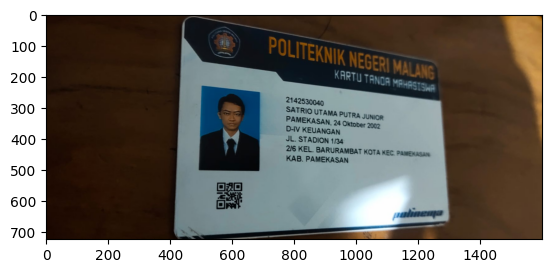

In [7]:
imgKTM = cv.imread('./Kelompok 6/3D_2141720105_3 - SYAIKHUL SHAFWAN R.jpeg')

# Dapatkan dimensi gambar
h, w = imgKTM.shape[:2]

# Jika lebar lebih kecil dari tinggi, berarti potrait
if w < h:

    # # Putar 90 derajat 
    # angle = 90
    
    # M = cv.getRotationMatrix2D((w/2,h/2), angle, 1)
    
    rotated  = cv.rotate(imgKTM, cv.ROTATE_90_CLOCKWISE)

else:

    # Jika landscape, tidak perlu rotasi
    rotated = imgKTM  

imgKTM = rotated.copy()
plt.imshow(cv.cvtColor(rotated, cv.COLOR_BGR2RGB))
plt.show()

In [8]:
def cv2_imshow(img, title='Image', size=None):
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  if size is not None:
    plt.figure(figsize=size)
  plt.imshow(img)
  plt.title(title)
  plt.show()

In [9]:
def detect_contour(edged):
  contours, _ = cv.findContours(edged, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv.contourArea, reverse=True)
  return max(contours, key=cv.contourArea)

In [10]:
def reflection(img):
  hsv_image = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  h, s, v = cv.split(hsv_image)

  clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  v = clahe.apply(v)

  hsv_image = cv.merge([h, s, v])
  return cv.cvtColor(hsv_image, cv.COLOR_HSV2BGR)

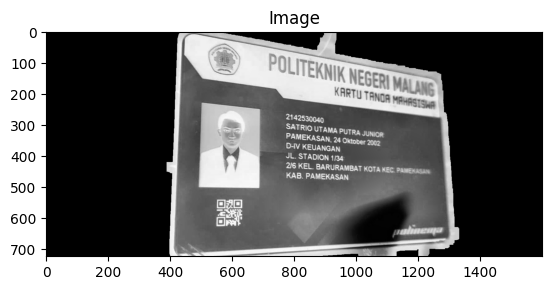

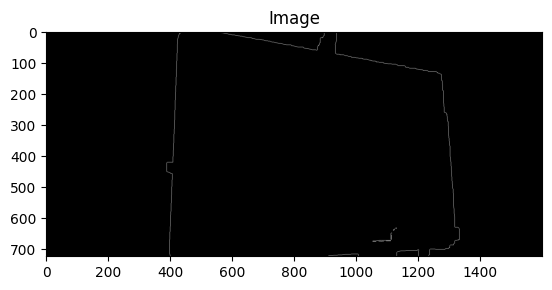

In [11]:
image = imgKTM.copy()

image = reflection(image)
inverted_img = cv.bitwise_not(image)
gray = cv.cvtColor(inverted_img, cv.COLOR_BGR2GRAY)
gray1 = cv.bilateralFilter(gray.copy(), 10, 15, 15)
gray1 = cv.medianBlur(gray1, 3)
edged = cv.Canny(gray1, 10, 40)
edged = cv.dilate(edged, np.ones((30, 30), dtype=np.int8))
# cv2_imshow(edged)

largest_contour = detect_contour(edged)
# Buat mask untuk menandai area dalam kontur
mask = np.zeros_like(gray)

# Gambar kontur pada mask
cv.drawContours(mask, [largest_contour], -1, (255, 0, 0), thickness=cv.FILLED)
mask = cv.bitwise_not(mask)
# Ubah warna dalam area kontur
gray[mask != 0] = 0
cv2_imshow(gray)
# cv2_imshow(gray)

# Potong bagian dari citra asli menggunakan koordinat yang ditemukan
# cropped_image = image[y:y+h, x:x+w]
# cv.drawContours(image, [contours[0]], -1, (0, 255, 0), 5)

# plt.imshow(toRGB(gray))
# edged = cv.dilate(gray, np.ones((1, 1), dtype=np.int8))
thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)[1]
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, np.ones((20, 20), dtype=np.int8))
edged = cv.Canny(opening, 20, 150)
cv2_imshow(edged)
# besar = detect_contour(edged)
# cv.drawContours(image, [besar], -1, (0, 255, 0), 2)
# cv2_imshow(image)

In [12]:
# image = imgKTM.copy()

# gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# # gray = cv.bilateralFilter(gray, 11, 17, 17)
# # gray = cv.medianBlur(gray, 9)
# # edged = cv.Canny(gray, 30, 400)
# hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

# # Tentukan batasan nilai untuk warna biru tua dalam ruang warna HSV
# lower_blue = np.array([90, 50, 50])
# upper_blue = np.array([130, 255, 255])

# # Buat mask untuk mengidentifikasi piksel dengan warna biru tua
# mask = cv.inRange(hsv, lower_blue, upper_blue)

# # Ganti warna biru tua menjadi warna putih pada gambar asli
# image[mask != 0] = [255, 255, 255]  # [B, G, R]
# edged = cv.Canny(image, 30, 400)
# plt.imshow(edged)

# plt.show()

length of countours  11


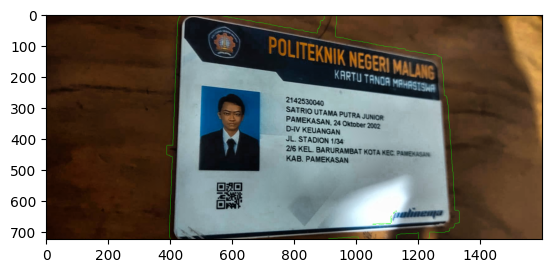

In [13]:
countours, hierarcy = cv.findContours(
    edged, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print('length of countours ', len(countours))
imageCopy = image.copy()

cv.drawContours(imageCopy, countours, -1, (0, 255, 0), 1)

plt.imshow(toRGB(imageCopy))
plt.show()

In [14]:
# approximate the contour
cnts = sorted(countours, key=cv.contourArea, reverse=True)
screenCntList = []
scrWidths = []
for cnt in cnts:
  peri = cv.arcLength(cnt, True)
  approx = cv.approxPolyDP(cnt, 0.05 * peri, True)
  screenCnt = approx
  print(len(approx))

  if (len(screenCnt) == 4):
    (X, Y, W, H) = cv.boundingRect(cnt)
    print('X Y W H', cnt)
    screenCntList.append(screenCnt)
    scrWidths.append(W)

  # else:
  #     print("4 points not found")

print('Screens found :', len(screenCntList))
print('Screen Dimentions', scrWidths)

4
X Y W H [[[ 937    0]]

 [[ 937   30]]

 [[ 936   31]]

 [[ 936   33]]

 [[ 935   34]]

 [[ 935   36]]

 [[ 934   37]]

 [[ 934   40]]

 [[ 933   41]]

 [[ 933   42]]

 [[ 932   43]]

 [[ 933   44]]

 [[ 933   71]]

 [[ 934   72]]

 [[ 935   72]]

 [[ 937   74]]

 [[ 946   74]]

 [[ 948   76]]

 [[ 960   76]]

 [[ 961   77]]

 [[ 962   77]]

 [[ 963   78]]

 [[ 964   78]]

 [[ 965   79]]

 [[ 972   79]]

 [[ 973   80]]

 [[ 974   80]]

 [[ 975   81]]

 [[ 983   81]]

 [[ 985   83]]

 [[ 985   84]]

 [[ 995   84]]

 [[ 996   85]]

 [[1000   85]]

 [[1001   86]]

 [[1007   86]]

 [[1008   87]]

 [[1018   87]]

 [[1020   89]]

 [[1023   89]]

 [[1024   90]]

 [[1035   90]]

 [[1036   91]]

 [[1039   91]]

 [[1041   93]]

 [[1046   93]]

 [[1048   95]]

 [[1052   95]]

 [[1053   96]]

 [[1062   96]]

 [[1065   99]]

 [[1073   99]]

 [[1074  100]]

 [[1087  100]]

 [[1088  101]]

 [[1088  102]]

 [[1089  103]]

 [[1093  103]]

 [[1094  104]]

 [[1101  104]]

 [[1102  105]]

 [[1114  105]]

Old Screen Dimentions filtered []
Screen Dimentions filtered [402, 358]
Mismatch in rect


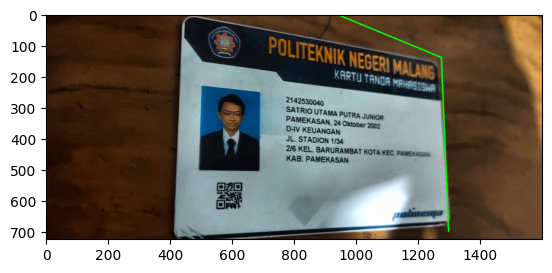

In [15]:
if(len(screenCntList) >= 2):
  screenCntList, scrWidths = findLargestCountours(screenCntList, scrWidths)

if not len(screenCntList) >= 2:  # there is no rectangle found
  print('No rectangle found')
elif scrWidths[0] != scrWidths[1]:  # mismatch in rect
  print('Mismatch in rect')

plt.imshow(toRGB(cv.drawContours(image.copy(), [screenCntList[0]], -1, (0, 255, 0), 3)))
plt.show()

In [16]:
pts = screenCntList[0].reshape(4, 2)
print('Found bill rectagle at ', pts)

Found bill rectagle at  [[ 937    0]
 [1275  139]
 [1298  698]
 [1275  139]]


[[ 937.    0.]
 [1275.  139.]
 [1298.  698.]
 [1298.  698.]]


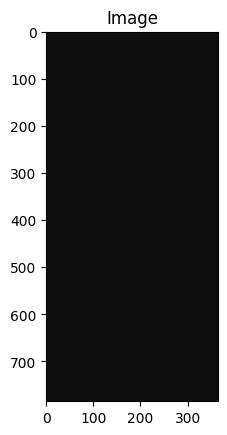

In [17]:
rect = order_points(pts)
print(rect)

# apply the four point tranform to obtain a "birds eye view" of
# the image
warped = four_point_transform(image, pts)

# convert the warped image to grayscale and then adjust
# the intensity of the pixels to have minimum and maximum
# values of 0 and 255, respectively
warp = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)
warp = exposure.rescale_intensity(warp)

img_asli = warped.copy()
cv2_imshow(warp)

In [18]:
# Define function for contour detection
def find_contours(img):
  conts = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method='left-to-right')[0]

  return conts

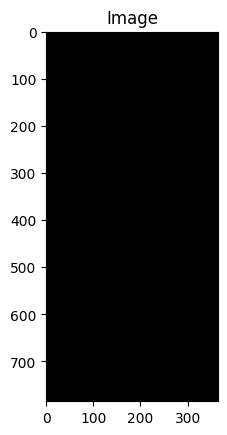

ValueError: not enough values to unpack (expected 2, got 0)

In [19]:
otsu = cv.threshold(warp, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
otsu = cv.bitwise_not(otsu)

canny = cv.Canny(otsu, 30, 400)
cv2_imshow(canny)

contours = find_contours(canny.copy())
cv.drawContours(warped, contours, -1, (0, 255, 0), 1)
cv2_imshow(warped)

In [ ]:
from keras.models import load_model
model = load_model("alphabet.model")
width, height = 13, 19
warp = img_asli.copy()

alphabet = []
for char_name in sorted(os.listdir("dataset")):
    alphabet.append(char_name)

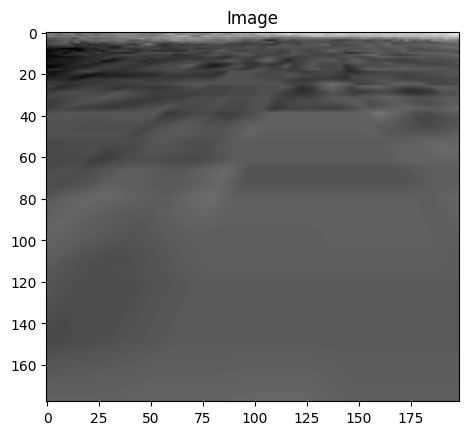

In [ ]:
min_w, max_w = 8, 160
min_h, max_h = 14, 140
num = 0
for c in contours:
  (x, y, w, h) = cv.boundingRect(c)  # find bounding box based on contour
  if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h): # if pixel follow this rule, it consider as char
    roi = img_asli[y:y+h, x:x+w]  # get region of interest for char
    roi = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)  # convert to grayscale
    roi = cv.resize(roi, (width, height))
    # thresh = cv.threshold(roi, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    roi = np.array(roi).reshape(-1, width, height, 1)
    roi = roi / 255.0
    prediction = model.predict(roi)
    cv.putText(warp, alphabet[np.argmax(prediction[0])],
               (x, y - 4), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    num += 1
    # Build bounding box on original image
    # cv.rectangle(warp, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Show bounding box on original image
cv2_imshow(warp)

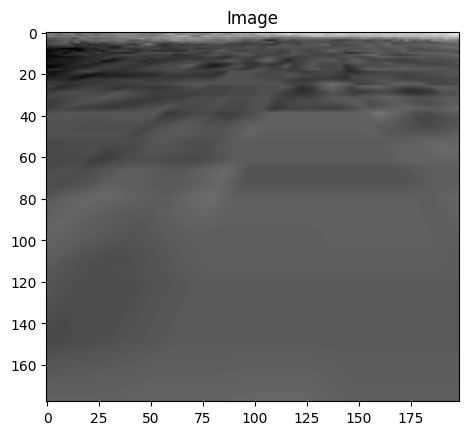

In [ ]:
min_w, max_w = 8, 160
min_h, max_h = 14, 140
num = 0
for c in contours:
  (x, y, w, h) = cv.boundingRect(c)  # find bounding box based on contour
  if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h): # if pixel follow this rule, it consider as char
    roi = img_asli[y:y+h, x:x+w]  # get region of interest for char
    # thresh = cv.threshold(roi, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    # cv2_imshow(roi, size=(0.6,0.5))  # check
    # cv.imwrite(f'./dataset/char_{num}.jpg', roi)  # save char
    num += 1
    # Build bounding box on original image
    # cv.rectangle(warp, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Show bounding box on original image
cv2_imshow(warp)